In [1]:
import os
import json
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score


In [2]:
# Copied from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
with open("../data/language_labels/output.json") as docs_file:
    docs = json.load(docs_file)

for doc in docs:
    doc["language"] = {
        "freeze": doc["language"]
    }

In [4]:
# spaCy language (CLD 2 based)
import spacy
from spacy_cld import LanguageDetector

nlp = spacy.load('nl_core_news_sm')
language_detector = LanguageDetector()
nlp.add_pipe(language_detector)

for doc in docs:
    text = nlp(doc["title"])
    language = "unknown"
    if len(text._.languages):
        language = text._.languages[0]
    doc["language"]["cld2"] = language


In [5]:
# CLD 3
import cld3

for doc in docs:
    language = cld3.get_language(doc["title"])
    doc["language"]["cld3"] = language.language if language and language.is_reliable else "unknown"


In [6]:
# langdetect (NLTK library 1)
from langdetect import detect

for doc in docs:
    language = detect(doc["title"])
    doc["language"]["langdetect"] = language if language else "unknown"


In [7]:
# langid (NLTK library 2)
from langid.langid import LanguageIdentifier, model

detector = LanguageIdentifier.from_modelstring(model, norm_probs=False)
detector.set_languages(['en','nl'])

for doc in docs:
    language = detector.classify(doc["title"])
    doc["language"]["langid"] = language[0] if language else "unknown"

In [8]:
y_true = []
y_cld2 = []
y_cld3 = []
y_langdetect = []
y_langid = []
y_freeze = []
for doc in docs:
    if "manual-entry" not in doc:
        continue
    y_true.append(doc["manual-entry"]["language"] or "unknown")
    y_freeze.append(doc["language"]["freeze"] or "unknown")
    y_cld2.append(doc["language"]["cld2"] or "unknown")
    y_cld3.append(doc["language"]["cld3"] or "unknown")
    y_langdetect.append(doc["language"]["langdetect"] or "unknown")
    y_langid.append(doc["language"]["langid"] or "unknown")


In [9]:
cld2_confusion = confusion_matrix(y_true, y_cld2)
cld2_accuracy = accuracy_score(y_true, y_cld2)
cld2_accuracy

0.7366666666666667

In [10]:
cld3_confusion = confusion_matrix(y_true, y_cld3)
cld3_accuracy = accuracy_score(y_true, y_cld3)
cld3_accuracy

0.48333333333333334

In [11]:
langdetect_confusion = confusion_matrix(y_true, y_langdetect)
langdetect_accuracy = accuracy_score(y_true, y_langdetect)
langdetect_accuracy

0.6733333333333333

In [12]:
langid_confusion = confusion_matrix(y_true, y_langid)
langid_accuracy = accuracy_score(y_true, y_langid)
langid_accuracy

0.91

Confusion matrix, without normalization
[[151   0   1   1   1   2  28]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [ 12   1   0  69   0   0  33]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1]]


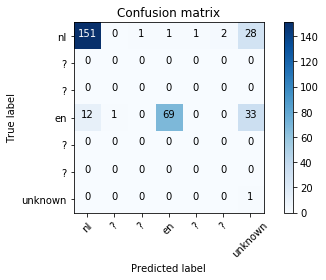

In [15]:
plot_confusion_matrix(cld2_confusion, ["nl", "?", "?", "en", "?", "?", "unknown"])

Confusion matrix, without normalization
[[178   6   0]
 [ 20  95   0]
 [  0   1   0]]


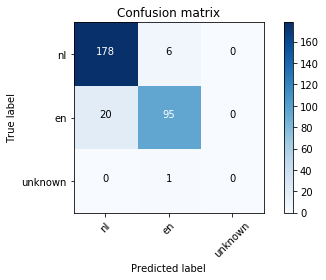

In [14]:
plot_confusion_matrix(langid_confusion, ["nl", "en", "unknown"])